# Analysis of the structrues generated by squidly

# Have a look at the times 

(0.0, 250.0)

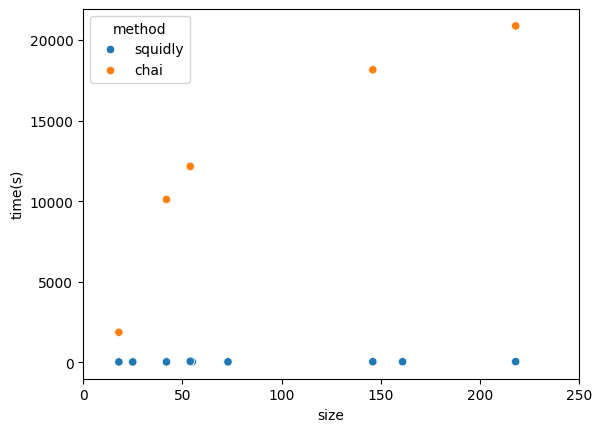

In [168]:
# read in the squidly predictions and convert them to the residues that they are
import pandas as pd
import os
from sciutil import SciUtil
import seaborn as sns
import numpy as np

u = SciUtil()
families = ['halogenase_NaBr', 'nitrilase_binary', 'esterase_binary']
time_squidly = pd.read_csv('time_log.txt')
time_chai = pd.read_csv('time_log_chai.txt')
time_chai_neg = pd.read_csv('time_log_chai_neg.txt')
time_chai_pos = pd.read_csv('time_log_chai_pos.txt')

time_df = pd.concat([time_squidly, time_chai, time_chai_neg, time_chai_pos])
time_df.dropna(inplace=True)
#time_df = time_df[time_df['dataset'].isin(families)]
g = sns.scatterplot(time_df, x='size', y='time(s)', hue='method')
g.set_xlim([0, 250])

# Import the residues

In [133]:
enzyme_files = os.listdir('data/')
files = os.listdir('squidly')
family_dict = {}
families = ['nitrilase_binary', 'aminotransferase', 'halogenase_NaBr', 
           'esterase_binary', 'halogenase_NaCl', 'olea']
all_df = pd.DataFrame()
for f in files: 
    df = pd.read_pickle(f'squidly/{f}')
    # squidly_as_pred_gt_acceptors_achiral_categorical.pkl'
    family = f.replace('squidly_as_pred_', '').replace('.pkl', '')
    if family in families:
        protein_df = pd.read_csv(f'data/{family}.csv', index_col=0)
        protein_df['label'] = [f'{family}_seq_{i}' for i in range(0, len(protein_df))]
        protein_df.set_index('label', inplace=True)
        df.set_index('label', inplace=True)
        df = df.join(protein_df, how='left')
        df['family_label'] = family
        # add in the CRS
        cr_res = []
        for pos, seq in df[['Squidly_CR_Position', 'SEQ']].values:
            seq = list(seq)
            if pos != '' and pos:
                residues = [seq[int(i)] for i in pos.split('|')]
            else:
                residues = []
            residues.sort()
            cr_res.append('|'.join(residues))
        df['Squidly_CR_Residues'] = cr_res
        family_dict[family] = df
        all_df = pd.concat([df, all_df])
        u.dp([family])

--------------------------------------------------------------------------------
                               aminotransferase	                                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                               nitrilase_binary	                                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                halogenase_NaBr	                                
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                esterase_binary	                                
--------------------------------------------------------------------------------
----------------------------

# Do a logo plot for each of the datasets

In [134]:
# Now we only want to look at some of them, the families of interest
for family in family_dict:
    u.dp([family])
    df = family_dict[family]
    # Check how many weren't able to be annotated
    print(df['Squidly_CR_Residues'].value_counts())
    

--------------------------------------------------------------------------------
                               aminotransferase	                                
--------------------------------------------------------------------------------
       16
Y|Y     4
K       3
H       1
G       1
Name: Squidly_CR_Residues, dtype: int64
--------------------------------------------------------------------------------
                               nitrilase_binary	                                
--------------------------------------------------------------------------------
C|E|K      16
C|D|E|K     1
C|E|E|K     1
Name: Squidly_CR_Residues, dtype: int64
--------------------------------------------------------------------------------
                                halogenase_NaBr	                                
--------------------------------------------------------------------------------
G|K      16
K        14
          8
C|D|K     1
G|H|K     1
G         1
G|T       1
Name: Squidly_C

## Finally let's check w.r.t the Chai structures

# Read in the total score for each structure


In [169]:
score_rows = []
for out_file in ['nohup.out', 'nohup.out.larger', 'nohup.out.txt']:
    with open(out_file, 'r+') as fin:
        for line in fin:
            # Score=0.5318, writing output to chai_positive/esterase_binary_seq_0/chai/pred.model_idx_0.cif
            if line.split('=')[0] == 'Score':
                score = float(line.split(',')[0].split('=')[1].strip())
                file_path = line.split(' ')[-1].strip()
                seq_name = file_path.split('/')[1]
                label = file_path.split('/')[0]
                family = file_path.split('/')[1].split('_seq')[0]
                score_rows.append([seq_name, score, label, family, file_path])

score_df = pd.DataFrame(score_rows, columns=['seq_name', 'score', 'label', 'family', 'file_path'])
score_df = score_df[score_df['label'] != 'chai']

<Axes: xlabel='family', ylabel='score'>

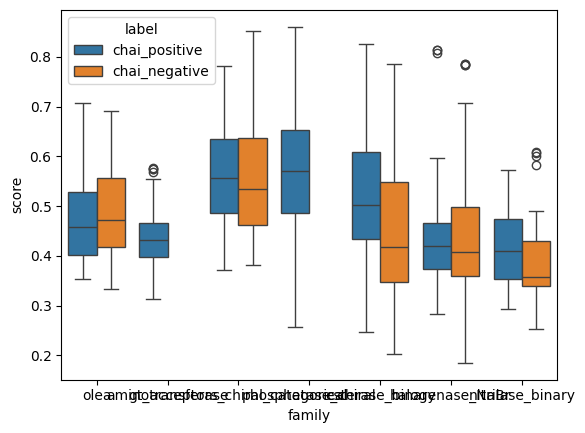

In [170]:
sns.boxplot(score_df, x='family', y='score', hue='label')

In [171]:
score_df.sort_values(by='score', ascending=False, inplace=True)
score_df = score_df.drop_duplicates(subset=['seq_name', 'label'])
score_df

,seq_name,score,label,family,file_path
1260,phosphatase_chiral_seq_78,0.8606,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_78/chai/p...
785,gt_acceptors_chiral_categorical_seq_21,0.8527,chai_negative,gt_acceptors_chiral_categorical,chai_negative/gt_acceptors_chiral_categorical_...
1594,phosphatase_chiral_seq_144,0.8512,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_144/chai/...
780,phosphatase_chiral_seq_26,0.8463,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_26/chai/p...
1201,phosphatase_chiral_seq_71,0.8406,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_71/chai/p...
...,...,...,...,...,...
2819,esterase_binary_seq_89,0.2446,chai_negative,esterase_binary,chai_negative/esterase_binary_seq_89/chai/pred...
2601,esterase_binary_seq_65,0.2382,chai_negative,esterase_binary,chai_negative/esterase_binary_seq_65/chai/pred...
2529,esterase_binary_seq_58,0.2217,chai_negative,esterase_binary,chai_negative/esterase_binary_seq_58/chai/pred...
2065,esterase_binary_seq_4,0.2200,chai_negative,esterase_binary,chai_negative/esterase_binary_seq_4/chai/pred....


In [172]:
# These are the ones we'll look at are just the positive ones
strutures = score_df[score_df['label'] != 'chai_negative']
strutures['cif_path'] = [f.replace('pred.model_idx', s) for s, f in  strutures[['seq_name', 'file_path']].values]# lastly we need to make the file path correct
strutures

/tmp/ipykernel_2466540/3601191910.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strutures['cif_path'] = [f.replace('pred.model_idx', s) for s, f in  strutures[['seq_name', 'file_path']].values]# lastly we need to make the file path correct


,seq_name,score,label,family,file_path,cif_path
1260,phosphatase_chiral_seq_78,0.8606,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_78/chai/p...,chai_positive/phosphatase_chiral_seq_78/chai/p...
1594,phosphatase_chiral_seq_144,0.8512,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_144/chai/...,chai_positive/phosphatase_chiral_seq_144/chai/...
780,phosphatase_chiral_seq_26,0.8463,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_26/chai/p...,chai_positive/phosphatase_chiral_seq_26/chai/p...
1201,phosphatase_chiral_seq_71,0.8406,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_71/chai/p...,chai_positive/phosphatase_chiral_seq_71/chai/p...
1357,phosphatase_chiral_seq_97,0.8332,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_97/chai/p...,chai_positive/phosphatase_chiral_seq_97/chai/p...
...,...,...,...,...,...,...
1774,phosphatase_chiral_seq_180,0.3005,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_180/chai/...,chai_positive/phosphatase_chiral_seq_180/chai/...
3017,esterase_binary_seq_116,0.2902,chai_positive,esterase_binary,chai_positive/esterase_binary_seq_116/chai/pre...,chai_positive/esterase_binary_seq_116/chai/est...
2968,esterase_binary_seq_111,0.2793,chai_positive,esterase_binary,chai_positive/esterase_binary_seq_111/chai/pre...,chai_positive/esterase_binary_seq_111/chai/est...
1193,phosphatase_chiral_seq_70,0.2686,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_70/chai/p...,chai_positive/phosphatase_chiral_seq_70/chai/p...


# For each family we'll pick the one with the best prediction for the positive and have a look at the squidly residues

In [173]:
ones_to_look_at = score_df.drop_duplicates(subset=['family', 'label'])
ones_to_look_at.set_index('seq_name', inplace=True) # Add in the 

In [174]:
ones_to_look_at = ones_to_look_at.join(all_df, how='left')
ones_to_look_at

,score,label,family,file_path,Squidly_CR_Position,Squidly_CR_probabilities,Squidly_CR_representations,SEQ,SUBSTRATES,log_slope,family_label,Squidly_CR_Residues,Conversion_NaCl,activity,Conversion_NaBr,Conversion,LogSpActivity,name
seq_name,,,,,,,,,,,,,,,,,,
phosphatase_chiral_seq_78,0.8606,chai_positive,phosphatase_chiral,chai_positive/phosphatase_chiral_seq_78/chai/p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gt_acceptors_chiral_categorical_seq_21,0.8527,chai_negative,gt_acceptors_chiral_categorical,chai_negative/gt_acceptors_chiral_categorical_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
esterase_binary_seq_99,0.8257,chai_positive,esterase_binary,chai_positive/esterase_binary_seq_99/chai/pred...,180|278|308,0.99603146|0.99943346|0.99384046,"[[-0.48555368, -0.18605821, -0.5958174, -0.590...",MGRAADQRARRLPPRTRSKLLPENLMQIDAHAKALLEGLAAQGMKG...,CCCC(=O)OC1=CC=CC2=CC=CC=C21,NaN,esterase_binary,D|H|S,NaN,1.0,NaN,NaN,NaN,esterase_binary_seq_99
halogenase_NaBr_seq_18,0.8146,chai_positive,halogenase_NaBr,chai_positive/halogenase_NaBr_seq_18/chai/pred...,14|78,0.9834593|0.99434304,"[[-0.35234135, -0.13501218, -0.42881477, -0.43...",MVEGQARSILIVGGGTAGWLTAAYLARFLGPETRITLLEDPAIGAI...,CC(O1)(C)C=CC2=C1C=CC3=C2OC[C@@H](C4=C(O)C=C(O...,NaN,halogenase_NaBr,G|K,NaN,NaN,0.652134,NaN,NaN,halogenase_NaBr_seq_18
halogenase_NaBr_seq_0,0.7864,chai_negative,halogenase_NaBr,chai_negative/halogenase_NaBr_seq_0/chai/pred....,12|76,0.9939579|0.99331665,"[[-0.43713057, -0.16501305, -0.53183806, -0.53...",MKPIKHVVIAGGGTAGWITAALLNKVLGKVIKITLIESSTIGTIGV...,CC(O1)(C)C=CC2=C1C=CC3=C2OC[C@@H](C4=C(O)C=C(O...,NaN,halogenase_NaBr,G|K,NaN,NaN,0.991682,NaN,NaN,halogenase_NaBr_seq_0
esterase_binary_seq_36,0.7850,chai_negative,esterase_binary,chai_negative/esterase_binary_seq_36/chai/pred...,14|191|194,0.99841416|0.9976927|0.99848676,"[[-0.5979454, -0.22679088, -0.733219, -0.72720...",MYFAAGSKLVIIGDSITDAGRDKGIGGEGLFNAHGSGYVALLNAHL...,CC(=O)OCC(C(C(C(C=O)OC(=O)C)OC(=O)C)OC(=O)C)OC...,NaN,esterase_binary,D|H|S,NaN,1.0,NaN,NaN,NaN,esterase_binary_seq_36
gt_acceptors_chiral_categorical_seq_47,0.7811,chai_positive,gt_acceptors_chiral_categorical,chai_positive/gt_acceptors_chiral_categorical_...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
olea_seq_4,0.7077,chai_positive,olea,chai_positive/olea_seq_4/chai/pred.model_idx_3...,96|122|264|294,0.9949269|0.99957985|0.9941499|0.99908566,"[[-0.42261875, -0.15914324, -0.52343774, -0.51...",MLFHHVAIAGLAHIDAPRRLTSEEINARLKPTLDRLGIRVDVLGDV...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.646311,olea,C|E|H|N,NaN,NaN,NaN,NaN,NaN,olea_seq_4
olea_seq_66,0.6906,chai_negative,olea,chai_negative/olea_seq_66/chai/pred.model_idx_...,110|136|279|309,0.9967913|0.99956816|0.9932462|0.9971143,"[[-0.48593265, -0.1834039, -0.6018384, -0.5884...",MLNASADKVGTNSDIRHANAALLSITHELPPDVVTSDYFDEQLAQT...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)CCCCCN=[N+]=[N-],1.624938,olea,C|E|H|N,NaN,NaN,NaN,NaN,NaN,olea_seq_66


In [141]:
ones_to_look_at['seq_name'] = ones_to_look_at.index

In [142]:
# First let's look through the positive structures.
import pickle as pkl

score_rows = []
for seq_path, seq_name, residues, in ones_to_look_at[['file_path', 'seq_name', 'Squidly_CR_Position']].values:
    try:
        for structure_label in ['positive', 'negative']:
            with open(f'chai_{structure_label}/{seq_name}/chai/{seq_name}.pkl', 'rb') as fin:
                structure = pkl.load(fin)
                for x in structure:
                    # Ligand is always at the end of the file so we just find the positions at the one we care
                    file_path = str(x[0])
                    seq_name = file_path.split('/')[1]
                    model_number = file_path.split('_')[-1].replace('.cif', '')
                    # Now we want the mean of the embeddings for the active site residues
                    scores = []
                    for residue in residues.split('|'):
                        scores.append(np.mean(np.array(x[1][:, int(residue)].detach())))
                    scores = np.array(scores)
                    score_rows.append([structure_label, seq_path, seq_name, model_number, np.mean(scores), np.min(scores), np.max(scores)])
    except:
        print(seq_path)

chai_positive/aminotransferase_seq_17/chai/pred.model_idx_0.cif
chai/davis_filtered_seq_7/chai/pred.model_idx_0.cif
chai_positive/esterase_binary_seq_99/chai/pred.model_idx_4.cif
chai_negative/gt_acceptors_chiral_categorical_seq_21/chai/pred.model_idx_4.cif
chai_positive/gt_acceptors_chiral_categorical_seq_47/chai/pred.model_idx_4.cif
chai_positive/phosphatase_chiral_seq_78/chai/pred.model_idx_0.cif


In [143]:
df = pd.DataFrame(score_rows, columns=['label', 'path', 'seq_name', 'model_number', 'mean_scores', 'min_scores', 'max_scores'])
df

,label,path,seq_name,model_number,mean_scores,min_scores,max_scores
0,positive,chai_positive/aminotransferase_seq_17/chai/pre...,aminotransferase_seq_17,0,3.161108,3.161108,3.161108
1,positive,chai_positive/aminotransferase_seq_17/chai/pre...,aminotransferase_seq_17,1,3.168922,3.168922,3.168922
2,positive,chai_positive/aminotransferase_seq_17/chai/pre...,aminotransferase_seq_17,2,3.166951,3.166951,3.166951
3,positive,chai_positive/aminotransferase_seq_17/chai/pre...,aminotransferase_seq_17,3,3.172088,3.172088,3.172088
4,positive,chai_positive/aminotransferase_seq_17/chai/pre...,aminotransferase_seq_17,4,3.195785,3.195785,3.195785
...,...,...,...,...,...,...,...
85,negative,chai_negative/olea_seq_66/chai/pred.model_idx_...,olea_seq_66,0,3.862400,3.614554,4.201754
86,negative,chai_negative/olea_seq_66/chai/pred.model_idx_...,olea_seq_66,1,3.911447,3.646524,4.254731
87,negative,chai_negative/olea_seq_66/chai/pred.model_idx_...,olea_seq_66,2,3.902697,3.624611,4.248848
88,negative,chai_negative/olea_seq_66/chai/pred.model_idx_...,olea_seq_66,3,3.872481,3.618644,4.213124


<Axes: xlabel='label', ylabel='mean_scores'>

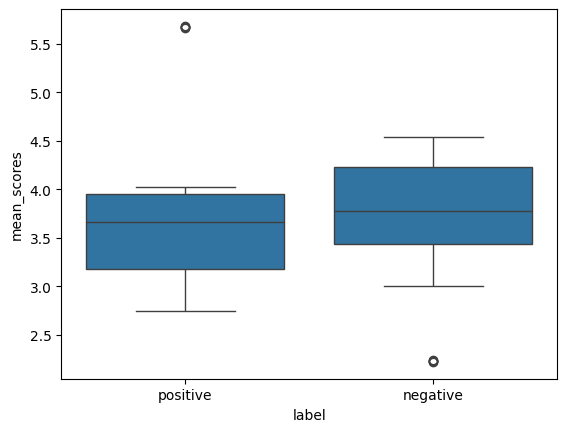

In [144]:
sns.boxplot(df, x='label', y='mean_scores')

In [145]:
all_df['name'] = all_df.index

# Comparison to SwissProt and BLAST

Here we downloaded all sequences from SwissProt using diamond blast
wget http://github.com/bbuchfink/diamond/releases/download/v2.1.11/diamond-linux64.tar.gz
tar xzf diamond-linux64.tar.gz


https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/complete/uniprot_sprot.fasta.gz


In [146]:
swissprot = pd.read_csv('swissprot.tsv', sep='\t') 
def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
# Now we're going to save this as a fasta file 
with open(f'swissprot_with_active_site_seqs.fasta', 'w+') as fout:
    for entry, seq in swissprot[['Entry', 'Sequence']].values:
        fout.write(f'>{entry}\n{seq}\n')

In [147]:
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/enzymetk/')
from steps.sequence_search_blast import BLAST
from steps.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
# This contains the models and the data needed to run the tool
id_col = 'name'
seq_col = 'SEQ'
all_df << (BLAST(id_col, seq_col, database='swissprot_with_active_site_seqs.fasta') >> Save('blast_enzyme_datasets.pkl'))

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: swissprot_with_active_site_seqs.fasta
Opening the database file...  [0.002s]
Loading sequences...  [0.194s]
Masking sequences...  [0.093s]
Writing sequences...  [0.042s]
Hashing sequences...  [0.012s]
Loading sequences...  [0s]
Writing trailer...  [0.003s]
Closing the input file...  [0s]
Closing the database file...  [0s]

Database sequences  106589
  Database letters  44751788
     Database hash  1430ef449a9079a7902cc7f80e811626
        Total time  0.350000s
diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and up

                           0       1     2    3    4   5   6    7   8    9   \
0                 olea_seq_53  Q8ERU6  79.2  312   65   0   1  312   1  312   
1                 olea_seq_53  Q5L1U1  71.5  312   87   1   1  312   1  310   
2                 olea_seq_53  A8FBX4  70.8  312   91   0   1  312   1  312   
3                 olea_seq_53  O34746  70.2  312   93   0   1  312   1  312   
4                 olea_seq_53  Q81JG0  68.3  312   97   1   1  312   1  310   
...                       ...     ...   ...  ...  ...  ..  ..  ...  ..  ...   
3456  aminotransferase_seq_12  K7QKH1  40.0  355  205   3   3  356  45  392   
3457  aminotransferase_seq_10  K7QHS5  40.1  337  191   4  41  377  82  407   
3458  aminotransferase_seq_10  K7QKH1  38.6  332  192   5  46  377  73  392   
3459  aminotransferase_seq_10  S3DQP8  32.2  320  205   4  60  374  40  352   
3460  aminotransferase_seq_22  Q8EXQ7  28.7  122   78   5  93  210  72  188   

                 10     11  
0     5.860000e-183  5

 [0.109s]
Deallocating reference...  [0.008s]
Loading reference sequences...  [0s]
Deallocating buffers...  [0s]
Deallocating queries...  [0s]
Loading query sequences...  [0s]
Closing the input file...  [0s]
Closing the output file...  [0.001s]
Closing the database...  [0.005s]
Cleaning up...  [0s]
Total time = 1.705s
Reported 3461 pairwise alignments, 3461 HSPs.
275 queries aligned.


,query,target,sequence identity,length,mismatch,gapopen,query start,query end,target start,target end,e-value,bitscore
0,olea_seq_53,Q8ERU6,79.2,312,65,0,1,312,1,312,5.860000e-183,508.0
1,olea_seq_53,Q5L1U1,71.5,312,87,1,1,312,1,310,1.370000e-162,456.0
2,olea_seq_53,A8FBX4,70.8,312,91,0,1,312,1,312,4.220000e-162,455.0
3,olea_seq_53,O34746,70.2,312,93,0,1,312,1,312,3.290000e-159,447.0
4,olea_seq_53,Q81JG0,68.3,312,97,1,1,312,1,310,2.760000e-155,437.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3456,aminotransferase_seq_12,K7QKH1,40.0,355,205,3,3,356,45,392,9.490000e-86,266.0
3457,aminotransferase_seq_10,K7QHS5,40.1,337,191,4,41,377,82,407,5.980000e-77,244.0
3458,aminotransferase_seq_10,K7QKH1,38.6,332,192,5,46,377,73,392,8.380000e-73,233.0
3459,aminotransferase_seq_10,S3DQP8,32.2,320,205,4,60,374,40,352,5.730000e-45,159.0


In [148]:
blast_df = pd.read_pickle('blast_enzyme_datasets.pkl')
blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
blast_df.drop_duplicates('query', inplace=True)
# Then join up with all df
blast_df.set_index('query', inplace=True)
df = all_df.join(blast_df, how='left')
df

,Squidly_CR_Position,Squidly_CR_probabilities,Squidly_CR_representations,SEQ,SUBSTRATES,log_slope,family_label,Squidly_CR_Residues,Conversion_NaCl,activity,...,sequence identity,length,mismatch,gapopen,query start,query end,target start,target end,e-value,bitscore
label,,,,,,,,,,,,,,,,,,,,,
olea_seq_53,111|236|266,0.9993605|0.999297|0.9991391,"[[-1.003859, -0.37819496, -1.2306405, -1.21800...",MNVGLLGTGHYVPTNVVTNKDMEKIVDTNDEWIRTRTGIEERRIAS...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.869941,olea,C|H|N,NaN,NaN,...,79.2,312.0,65.0,0.0,1.0,312.0,1.0,312.0,5.860000e-183,508.0
olea_seq_26,88|112|254|284,0.8852054|0.9995559|0.9981932|0.99615246,"[[-0.2850058, -0.105149336, -0.35419953, -0.34...",MNVGITGIAYALPAREVTTAELQRRVAPKLPPRMFEQATGITRRRV...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.312501,olea,C|E|H|N,NaN,NaN,...,32.4,327.0,203.0,7.0,2.0,318.0,3.0,321.0,6.050000e-32,123.0
olea_seq_57,89|90|113|254|284,0.9481426|0.6729754|0.9995178|0.9972077|0.9983012,"[[-0.31929022, -0.11822759, -0.39672855, -0.38...",MGTQLAGVAVHLPEQQVSTTEVERRLAPFTPPAGLIHRLTGVESRH...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)CCCCCN=[N+]=[N-],1.816848,olea,C|E|H|N|P,NaN,NaN,...,33.5,325.0,198.0,8.0,7.0,327.0,8.0,318.0,2.780000e-36,134.0
olea_seq_34,114|257|287,0.99953496|0.9987753|0.99928325,"[[-1.317718, -0.49703264, -1.6180372, -1.60238...",MKRNIKITGIGSYLPKRIVDGAEIDKIIGAKNGWSEKKSGVKQRYF...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.136902,olea,C|H|N,NaN,NaN,...,34.1,331.0,201.0,4.0,1.0,331.0,1.0,314.0,1.810000e-62,202.0
olea_seq_65,116|259|289,0.9995528|0.99893636|0.9994293,"[[-1.4241276, -0.5363803, -1.7465913, -1.73068...",MQLRRVRIAGTGKYLPQMKVTDEELDERLHVPAGWVSKATGVGYRY...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.639129,olea,C|H|N,NaN,NaN,...,33.9,333.0,199.0,6.0,7.0,332.0,6.0,324.0,3.490000e-52,176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aminotransferase_seq_21,,,[],MDYVTLASHAVRQYAPDQIFTASQRAKADAAALGEDAVINATLGEC...,CC(C)C[C@@H](C(=O)O)N,NaN,aminotransferase,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aminotransferase_seq_0,97|159,0.72585917|0.90904826,"[[-0.23624305, -0.09008575, -0.29099208, -0.28...",MTIQLKDLGKAVLETEYAVRGPIVARAQELEREGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aminotransferase_seq_2,97|164,0.6371372|0.9783386,"[[-0.22223513, -0.08313126, -0.27423277, -0.27...",MPLQKSDLSDAVINTYYAVRGPIVARAQQLENSGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [149]:
uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
for name, seq, uniprot in df[['name', 'SEQ', 'target']].values:
    fin = f'msa/{uniprot}_{name}.fa'
    with open(fin, 'w+') as fout:
        fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
        fout.write(f'>{name}\n{seq}')
    # Now run clustalomega
    os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')

In [150]:
# Drop the missing ones
df[df['target'].isna()]

,Squidly_CR_Position,Squidly_CR_probabilities,Squidly_CR_representations,SEQ,SUBSTRATES,log_slope,family_label,Squidly_CR_Residues,Conversion_NaCl,activity,...,sequence identity,length,mismatch,gapopen,query start,query end,target start,target end,e-value,bitscore
label,,,,,,,,,,,,,,,,,,,,,
olea_seq_23,89|113|289,0.78161615|0.9995796|0.99946624,"[[-0.22860424, -0.08701122, -0.28369468, -0.27...",MRFENDLYIASTASWLPDLVPMEEAIAAGLVDDEHRNLGYESIAVA...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.39774,olea,C|H|W,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
halogenase_NaCl_seq_38,75,0.8366685,"[[-0.24788496, -0.091189995, -0.30383348, -0.2...",MPIVEMERRQVVIIGAGPSGAIAAALLKRKGHDVLVIERQHFPRFS...,[H][C@](N1CC2)(C[C@@]([C@@H](C(OC)=O)[C@@H](O)...,NaN,halogenase_NaCl,K,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
halogenase_NaCl_seq_16,,,[],MSKEFVDVLVIGAGPSGCVSSSYLKKNNVNVKVVEKTKFPRLVVGE...,OC1=CC(O)=CC=C1C(C)=O,NaN,halogenase_NaCl,,0.070003,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
halogenase_NaCl_seq_17,46|48|208,0.9992495|0.99609804|0.9967204,"[[-0.7792644, -0.29151255, -0.9518822, -0.9478...",MDIDEYDVVVAGAGTAGCYAAATIANEGLDVVIVERKDAEEAGHIA...,O=C1CC(C2=CC=C(O)C=C2)OC3=CC=CC=C31,NaN,halogenase_NaCl,C|D|K,0.064508,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
halogenase_NaCl_seq_28,71,0.98513085,"[[-0.37586993, -0.14082995, -0.46254107, -0.45...",MRATTQILVIGGGPAGSTAAGLLAKEGFEVTLLERDHFPRYHIGES...,OC1=CC=C(N=CC=C2)C2=C1,NaN,halogenase_NaCl,K,0.022405,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aminotransferase_seq_21,,,[],MDYVTLASHAVRQYAPDQIFTASQRAKADAAALGEDAVINATLGEC...,CC(C)C[C@@H](C(=O)O)N,NaN,aminotransferase,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aminotransferase_seq_0,97|159,0.72585917|0.90904826,"[[-0.23624305, -0.09008575, -0.29099208, -0.28...",MTIQLKDLGKAVLETEYAVRGPIVARAQELEREGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aminotransferase_seq_2,97|164,0.6371372|0.9783386,"[[-0.22223513, -0.08313126, -0.27423277, -0.27...",MPLQKSDLSDAVINTYYAVRGPIVARAQQLENSGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))
# Read in each alignment and then find the position of the active site predicted by BLAST
from Bio import AlignIO
predicted_active_sites = {}
missing = 0
for query, uniprot in df[['name', 'target']].values:
    try:
        fin = f'msa/{uniprot}_{query}.msa'
        # Read with bioseq
        # Read the alignment
        active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
        alignment = AlignIO.read(fin, 'fasta')
        # get the existing one and then calculate the position gapped
        records = {}
        for record in alignment:
            records[record.id] = record.seq
        # Now get the active site
        position_count = 0
        active_pred = []
        query_seq = records[query]
        query_count = 0
        for i, v in enumerate(records[uniprot]):
            if position_count in active_sites:
                if query_count < len(query_seq.replace('-', '')):
                    active_pred.append(query_count)
                if query_seq[i] != v:
                    print(query, uniprot, v, query_seq[i])
            if v != '-':
                position_count += 1
            if query_seq[i] != '-' and query_seq[i] != ' ':
                query_count += 1
    
        predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
        # Now we can just add on the
    except:
        missing += 1

olea_seq_64 A0AKV5 H T
olea_seq_69 Q0TRH0 H T
halogenase_NaCl_seq_31 A8CF74 K T
esterase_binary_seq_81 P95125 D -
esterase_binary_seq_81 P95125 H -
esterase_binary_seq_79 Q8KQK1 D -
esterase_binary_seq_56 Q6IE26 D S
esterase_binary_seq_39 P95125 H N
esterase_binary_seq_66 Q99685 H -
esterase_binary_seq_21 A1AD14 D E
esterase_binary_seq_53 Q8K4H1 H A
esterase_binary_seq_19 Q6P093 D -
esterase_binary_seq_19 Q6P093 H W
esterase_binary_seq_82 Q02104 E S
esterase_binary_seq_40 P18773 E D
esterase_binary_seq_141 Q8LED9 S -
esterase_binary_seq_141 Q8LED9 D E
esterase_binary_seq_9 Q9LK21 S -
esterase_binary_seq_9 Q9LK21 D E
esterase_binary_seq_51 P95125 H -
esterase_binary_seq_86 Q5Z9I2 H K
esterase_binary_seq_63 Q5SK89 - D
esterase_binary_seq_63 Q5SK89 D R
esterase_binary_seq_2 Q02104 E S
esterase_binary_seq_18 P22760 D -
esterase_binary_seq_18 P22760 H G
esterase_binary_seq_25 Q8R431 D G
esterase_binary_seq_3 L0TC47 D E
esterase_binary_seq_1 Q02104 E S
esterase_binary_seq_16 Q6P093 D E
ester

In [152]:
df['BLAST_residues'] = [predicted_active_sites.get(label) for label in df['name'].values]
df

,Squidly_CR_Position,Squidly_CR_probabilities,Squidly_CR_representations,SEQ,SUBSTRATES,log_slope,family_label,Squidly_CR_Residues,Conversion_NaCl,activity,...,length,mismatch,gapopen,query start,query end,target start,target end,e-value,bitscore,BLAST_residues
label,,,,,,,,,,,,,,,,,,,,,
olea_seq_53,111|236|266,0.9993605|0.999297|0.9991391,"[[-1.003859, -0.37819496, -1.2306405, -1.21800...",MNVGLLGTGHYVPTNVVTNKDMEKIVDTNDEWIRTRTGIEERRIAS...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.869941,olea,C|H|N,NaN,NaN,...,312.0,65.0,0.0,1.0,312.0,1.0,312.0,5.860000e-183,508.0,111|236|266
olea_seq_26,88|112|254|284,0.8852054|0.9995559|0.9981932|0.99615246,"[[-0.2850058, -0.105149336, -0.35419953, -0.34...",MNVGITGIAYALPAREVTTAELQRRVAPKLPPRMFEQATGITRRRV...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.312501,olea,C|E|H|N,NaN,NaN,...,327.0,203.0,7.0,2.0,318.0,3.0,321.0,6.050000e-32,123.0,112
olea_seq_57,89|90|113|254|284,0.9481426|0.6729754|0.9995178|0.9972077|0.9983012,"[[-0.31929022, -0.11822759, -0.39672855, -0.38...",MGTQLAGVAVHLPEQQVSTTEVERRLAPFTPPAGLIHRLTGVESRH...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)CCCCCN=[N+]=[N-],1.816848,olea,C|E|H|N|P,NaN,NaN,...,325.0,198.0,8.0,7.0,327.0,8.0,318.0,2.780000e-36,134.0,113|254|284
olea_seq_34,114|257|287,0.99953496|0.9987753|0.99928325,"[[-1.317718, -0.49703264, -1.6180372, -1.60238...",MKRNIKITGIGSYLPKRIVDGAEIDKIIGAKNGWSEKKSGVKQRYF...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.136902,olea,C|H|N,NaN,NaN,...,331.0,201.0,4.0,1.0,331.0,1.0,314.0,1.810000e-62,202.0,114|257|287
olea_seq_65,116|259|289,0.9995528|0.99893636|0.9994293,"[[-1.4241276, -0.5363803, -1.7465913, -1.73068...",MQLRRVRIAGTGKYLPQMKVTDEELDERLHVPAGWVSKATGVGYRY...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.639129,olea,C|H|N,NaN,NaN,...,333.0,199.0,6.0,7.0,332.0,6.0,324.0,3.490000e-52,176.0,116|259|289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aminotransferase_seq_21,,,[],MDYVTLASHAVRQYAPDQIFTASQRAKADAAALGEDAVINATLGEC...,CC(C)C[C@@H](C(=O)O)N,NaN,aminotransferase,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
aminotransferase_seq_0,97|159,0.72585917|0.90904826,"[[-0.23624305, -0.09008575, -0.29099208, -0.28...",MTIQLKDLGKAVLETEYAVRGPIVARAQELEREGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
aminotransferase_seq_2,97|164,0.6371372|0.9783386,"[[-0.22223513, -0.08313126, -0.27423277, -0.27...",MPLQKSDLSDAVINTYYAVRGPIVARAQQLENSGKEIIYCNIGNPQ...,C[C@@H](C(=O)O)N,NaN,aminotransferase,Y|Y,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None


In [153]:
# Check the agreement:
agree, disagree, none_ = 0, 0, 0
percent_aggree = []
to_check = []
for seq_label, res_sq, res_blast in df[['name', 'Squidly_CR_Position', 'BLAST_residues']].values:
    if res_sq != res_blast:
        to_check.append(seq_label)
        if not res_blast:
            none_ += 1
            percent_aggree.append(None)
        else:
            # Check the % agree 
            res_sq = res_sq.split('|')
            res_blast = res_blast.split('|')
            percent_aggree.append(len(set(res_sq) & set(res_blast))/max(len(res_sq), len(res_blast)))
            disagree += 1
    else:
        percent_aggree.append(1)
        agree += 1
print(agree, disagree, none_)

93 182 71


In [175]:
df['percent_agree'] = percent_aggree

In [176]:
np.nanmean(df[~df['percent_agree'].isna()]['percent_agree'].values)

0.6582424242424242

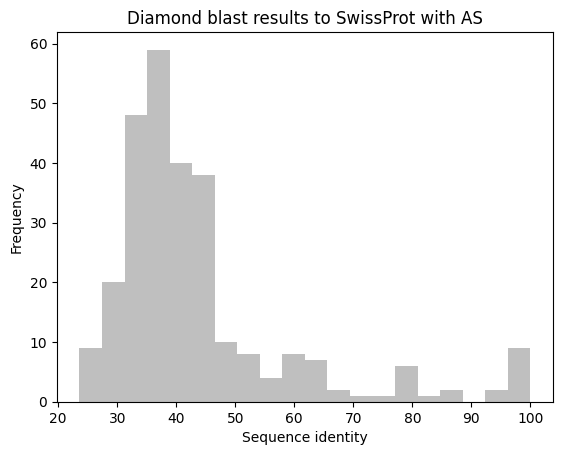

In [156]:
import matplotlib.pyplot as plt
plt.hist(df['sequence identity'].values, bins=20, color='grey', alpha=0.5)
plt.title('Diamond blast results to SwissProt with AS')
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
plt.savefig('Figures/DiamondBlast_histogram.svg')

In [157]:
df[df['sequence identity'] > 90]['family_label'].value_counts()

esterase_binary     4
nitrilase_binary    3
olea                2
halogenase_NaCl     1
halogenase_NaBr     1
Name: family_label, dtype: int64

In [158]:
# Do the same with foldseek
from steps.similarity_foldseek_step import FoldSeek

# This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
# This contains the models and the data needed to run the tool
output_dir = 'tmp/'
# foldseek_dir: str, pdb_column_name: str, reference_database: str
pdb_column_name = 'cif_path'
reference_database = '/disk1/share/software/foldseek/structures/pdb/pdb'
strutures << (FoldSeek(pdb_column_name, reference_database) >> Save(f'pdb_files.pkl'))

easy-search chai/davis_filtered_seq_7/chai/davis_filtered_seq_7_0.cif chai/davis_filtered_seq_4/chai/davis_filtered_seq_4_3.cif chai/davis_filtered_seq_0/chai/davis_filtered_seq_0_0.cif chai/davis_filtered_seq_2/chai/davis_filtered_seq_2_4.cif chai/davis_filtered_seq_3/chai/davis_filtered_seq_3_2.cif chai/davis_filtered_seq_8/chai/davis_filtered_seq_8_2.cif chai/davis_filtered_seq_5/chai/davis_filtered_seq_5_1.cif chai_positive/phosphatase_chiral_seq_78/chai/phosphatase_chiral_seq_78_0.cif chai/davis_filtered_seq_1/chai/davis_filtered_seq_1_1.cif chai_positive/phosphatase_chiral_seq_144/chai/phosphatase_chiral_seq_144_4.cif chai_positive/phosphatase_chiral_seq_26/chai/phosphatase_chiral_seq_26_3.cif chai_positive/phosphatase_chiral_seq_71/chai/phosphatase_chiral_seq_71_4.cif chai_positive/phosphatase_chiral_seq_97/chai/phosphatase_chiral_seq_97_2.cif chai_positive/esterase_binary_seq_99/chai/esterase_binary_seq_99_4.cif chai_positive/halogenase_NaBr_seq_18/chai/halogenase_NaBr_seq_18_4

,Query,Target,Calpha coordinates of the query,Calpha coordinates of the target,TM-score of the alignment,TM-score normalized by the query length,TM-score normalized by the target length,Rotation matrix (computed to by TM-score),Translation vector (computed to by TM-score),Average LDDT of the alignment,LDDT per aligned position,Estimated probability for query and target to be homologous
0,davis_filtered_seq_0_0_A,6hvd-assembly1.cif.gz_A,0.976,259,6,0,1,259,18,270,2.022000e-41,1499
1,davis_filtered_seq_0_0_A,2j51-assembly1.cif.gz_A,1.000,259,0,0,1,259,15,273,1.610000e-42,1489
2,davis_filtered_seq_0_0_A,2uv2-assembly1.cif.gz_A-2,0.992,259,2,0,1,259,15,271,1.014000e-41,1471
3,davis_filtered_seq_0_0_A,8bem-assembly1.cif.gz_G,0.911,259,21,0,1,259,19,256,2.010000e-38,1460
4,davis_filtered_seq_0_0_A,8bem-assembly1.cif.gz_A,0.915,259,20,0,1,259,19,258,8.983000e-39,1460
...,...,...,...,...,...,...,...,...,...,...,...,...
462587,phosphatase_chiral_seq_132_4_A,7lg5-assembly1.cif.gz_A,0.070,264,239,0,1,264,606,863,8.405000e+00,11
462588,phosphatase_chiral_seq_132_4_A,5tvg-assembly5.cif.gz_G,0.091,261,233,0,12,268,143,403,8.946000e+00,10
462589,phosphatase_chiral_seq_132_4_A,5tvg-assembly6.cif.gz_H,0.102,276,239,0,4,270,134,409,8.946000e+00,10
462590,phosphatase_chiral_seq_132_4_A,7bvb-assembly1.cif.gz_A,0.101,261,178,0,4,264,8,206,8.946000e+00,10


In [159]:
foldseek_df = pd.read_pickle('pdb_files.pkl')

foldseek_df['query'] = ['_'.join(c.split('_')[:-2]) for c in foldseek_df['Query'].values]
foldseek_df

,Query,Target,Calpha coordinates of the query,Calpha coordinates of the target,TM-score of the alignment,TM-score normalized by the query length,TM-score normalized by the target length,Rotation matrix (computed to by TM-score),Translation vector (computed to by TM-score),Average LDDT of the alignment,LDDT per aligned position,Estimated probability for query and target to be homologous,query
0,davis_filtered_seq_0_0_A,6hvd-assembly1.cif.gz_A,0.976,259,6,0,1,259,18,270,2.022000e-41,1499,davis_filtered_seq_0
1,davis_filtered_seq_0_0_A,2j51-assembly1.cif.gz_A,1.000,259,0,0,1,259,15,273,1.610000e-42,1489,davis_filtered_seq_0
2,davis_filtered_seq_0_0_A,2uv2-assembly1.cif.gz_A-2,0.992,259,2,0,1,259,15,271,1.014000e-41,1471,davis_filtered_seq_0
3,davis_filtered_seq_0_0_A,8bem-assembly1.cif.gz_G,0.911,259,21,0,1,259,19,256,2.010000e-38,1460,davis_filtered_seq_0
4,davis_filtered_seq_0_0_A,8bem-assembly1.cif.gz_A,0.915,259,20,0,1,259,19,258,8.983000e-39,1460,davis_filtered_seq_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462587,phosphatase_chiral_seq_132_4_A,7lg5-assembly1.cif.gz_A,0.070,264,239,0,1,264,606,863,8.405000e+00,11,phosphatase_chiral_seq_132
462588,phosphatase_chiral_seq_132_4_A,5tvg-assembly5.cif.gz_G,0.091,261,233,0,12,268,143,403,8.946000e+00,10,phosphatase_chiral_seq_132
462589,phosphatase_chiral_seq_132_4_A,5tvg-assembly6.cif.gz_H,0.102,276,239,0,4,270,134,409,8.946000e+00,10,phosphatase_chiral_seq_132
462590,phosphatase_chiral_seq_132_4_A,7bvb-assembly1.cif.gz_A,0.101,261,178,0,4,264,8,206,8.946000e+00,10,phosphatase_chiral_seq_132


In [37]:
foldseek_df = foldseek_df.sort_values(by='Calpha coordinates of the query', ascending=False)
foldseek_df.drop_duplicates('query', inplace=True)
# Then join up with all df
foldseek_df.set_index('query', inplace=True)
df = all_df.join(foldseek_df, how='left')
df

,Squidly_CR_Position,Squidly_CR_probabilities,Squidly_CR_representations,SEQ,SUBSTRATES,log_slope,family_label,Squidly_CR_Residues,Conversion_NaCl,Conversion,...,Calpha coordinates of the query,Calpha coordinates of the target,TM-score of the alignment,TM-score normalized by the query length,TM-score normalized by the target length,Rotation matrix (computed to by TM-score),Translation vector (computed to by TM-score),Average LDDT of the alignment,LDDT per aligned position,Estimated probability for query and target to be homologous
label,,,,,,,,,,,,,,,,,,,,,
olea_seq_53,111|236|266,0.9993605|0.999297|0.9991391,"[[-1.003859, -0.37819496, -1.2306405, -1.21800...",MNVGLLGTGHYVPTNVVTNKDMEKIVDTNDEWIRTRTGIEERRIAS...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.869941,olea,C|H|N,NaN,NaN,...,0.583,312.0,129.0,0.0,1.0,311.0,1.0,312.0,8.556000e-58,1879.0
olea_seq_26,88|112|254|284,0.8852054|0.9995559|0.9981932|0.99615246,"[[-0.2850058, -0.105149336, -0.35419953, -0.34...",MNVGITGIAYALPAREVTTAELQRRVAPKLPPRMFEQATGITRRRV...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.312501,olea,C|E|H|N,NaN,NaN,...,0.300,326.0,227.0,0.0,2.0,326.0,3.0,328.0,1.607000e-33,1050.0
olea_seq_57,89|90|113|254|284,0.9481426|0.6729754|0.9995178|0.9972077|0.9983012,"[[-0.31929022, -0.11822759, -0.39672855, -0.38...",MGTQLAGVAVHLPEQQVSTTEVERRLAPFTPPAGLIHRLTGVESRH...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)CCCCCN=[N+]=[N-],1.816848,olea,C|E|H|N|P,NaN,NaN,...,0.363,22.0,13.0,0.0,122.0,143.0,246.0,267.0,6.842000e+00,21.0
olea_seq_34,114|257|287,0.99953496|0.9987753|0.99928325,"[[-1.317718, -0.49703264, -1.6180372, -1.60238...",MKRNIKITGIGSYLPKRIVDGAEIDKIIGAKNGWSEKKSGVKQRYF...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,2.136902,olea,C|H|N,NaN,NaN,...,0.419,329.0,189.0,0.0,3.0,331.0,2.0,328.0,2.501000e-45,1486.0
olea_seq_65,116|259|289,0.9995528|0.99893636|0.9994293,"[[-1.4241276, -0.5363803, -1.7465913, -1.73068...",MQLRRVRIAGTGKYLPQMKVTDEELDERLHVPAGWVSKATGVGYRY...,O=C(OC1=CC=C([N+]([O-])=O)C=C1)COCCOCCCC,1.639129,olea,C|H|N,NaN,NaN,...,0.353,330.0,211.0,0.0,4.0,333.0,2.0,328.0,1.760000e-41,1327.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
davis_filtered_seq_6,8|225,0.926339|0.9993599,"[[-0.27210897, -0.10038704, -0.33083922, -0.33...",VLGRTLGSGAFGQVVEATAHGLSHSQATMKVAVKMLKSTARSSEKQ...,CCN(CC)CCNC(=O)c1c(C)[nH]c(/C=C2\C(=O)Nc3ccc(F...,NaN,davis_filtered,D|G,NaN,NaN,...,0.578,355.0,119.0,0.0,1.0,355.0,41.0,322.0,2.244000e-34,1251.0
davis_filtered_seq_41,8|224,0.9848445|0.99935347,"[[-0.36623126, -0.13643773, -0.44513866, -0.44...",VLGRVLGSGAFGKVVEGTAYGLSRSQPVMKVAVKMLKPTARSSEKQ...,COc1cc2c(Oc3ccc4[nH]c(C)cc4c3F)ncnc2cc1OCCCN1C...,NaN,davis_filtered,D|G,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
davis_filtered_seq_224,132,0.99927706,"[[-0.94357353, -0.3607537, -1.1664466, -1.1514...",HVVRKLGWGHFSTVWLCWDIQRKRFVALKVVKSAGHYTETAVDEIK...,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc(N(C)C(=O...,NaN,davis_filtered,D,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


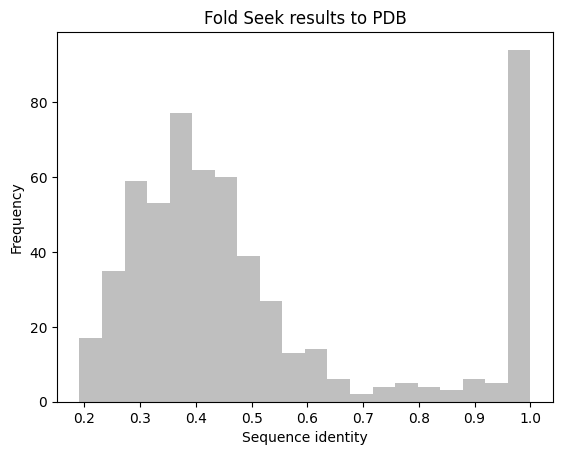

In [43]:
import matplotlib.pyplot as plt
plt.hist(df['Calpha coordinates of the query'].values, bins=20, color='grey', alpha=0.5)
plt.title('Fold Seek results to PDB')
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')
plt.savefig('Figures/FoldSeek_histogram.svg')

## Now for each match we're going to do a pairwise alignment and then take the active site from the best match

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Fragment,Active site,Binding site,EC number,Cofactor
0,A0A009IHW8,reviewed,ABTIR_ACIB9,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,J512_3302,Acinetobacter baumannii (strain 1295743),269,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,NaN,"ACT_SITE 208; /evidence=""ECO:0000255|PROSITE-P...","BINDING 143; /ligand=""NAD(+)""; /ligand_id=""ChE...",3.2.2.-; 3.2.2.6,NaN
1,A0A023I7E1,reviewed,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",ENG1 LAM81A,Rhizomucor miehei,796,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,NaN,"ACT_SITE 500; /evidence=""ECO:0000255|PROSITE-P...","BINDING 504; /ligand=""(1,3-beta-D-glucosyl)n"";...",3.2.1.39,NaN
2,A0A024B7W1,reviewed,POLG_ZIKVF,Genome polyprotein [Cleaved into: Capsid prote...,NaN,Zika virus (isolate ZIKV/Human/French Polynesi...,3423,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,NaN,"ACT_SITE 1553; /note=""Charge relay system; for...","BINDING 1696..1703; /ligand=""ATP""; /ligand_id=...",2.1.1.56; 2.1.1.57; 2.7.7.48; 3.4.21.91; 3.6.1...,NaN
3,A0A024RXP8,reviewed,GUX1_HYPJR,"Exoglucanase 1 (EC 3.2.1.91) (1,4-beta-cellobi...",cbh1 M419DRAFT_125125,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,514,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,NaN,"ACT_SITE 229; /note=""Nucleophile""; /evidence=""...",NaN,3.2.1.91,NaN
4,A0A024SC78,reviewed,CUTI1_HYPJR,Cutinase (EC 3.1.1.74),M419DRAFT_76732,Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,248,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,NaN,"ACT_SITE 164; /note=""Nucleophile""; /evidence=""...",NaN,3.1.1.74,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
572965,V9HVX0,reviewed,YPAA_ECOLI,Uncharacterized protein YpaA,ypaA b4543,Escherichia coli (strain K12),61,MTIAERLRQEGHQIGWQEGKLEGLHEQAIKIALRMLEQGFDRDQVL...,NaN,NaN,NaN,NaN,NaN
572966,W5X2N3,reviewed,AP_FRAAN,Fra a 1-associated protein (FaAP),AP,Fragaria ananassa (Strawberry) (Fragaria chilo...,193,MGWVWKDDDEQGGHVNPSAADISPRLDGDRCSTRKVVRTQCKTEEV...,NaN,NaN,NaN,NaN,NaN
572967,W6JGV7,reviewed,REP_CPBDV,Replication-associated protein (Rep) (Viral pr...,NaN,Chaetoceros protobacilladnavirus 2 (Chaetocero...,484,MSAPLSIEQDDLLTDDLKSWLSDIDFSNDNEEAIEMEPSDIEMSSP...,NaN,NaN,NaN,NaN,NaN
572968,W6JHZ8,reviewed,VP1_CPBDV,Viral protein 1 (VP1),NaN,Chaetoceros protobacilladnavirus 2 (Chaetocero...,210,MNVKGASDKAQLAMQAEWEEVLAPEGALAVEEASSVLKISDDERRS...,NaN,NaN,NaN,NaN,NaN
